# Tandem MS database search using a decoy-based strategy

This documentation describes the various methods implemented in the ms2matcher package. First, we will provide a short demonstration on how to use the package and later we will show how the underlying functions work and the intermediate output that they provide.

In addition to this document, the main functions can all be found in the \ms2matcher folder in the main module file ms2matcher.py. All methods are documented according to the  NumPy/SciPy style convention (https://github.com/numpy/numpy/blob/master/doc/HOWTO_DOCUMENT.rst.txt), providing a clear overview of the required inputs and delivered outputs for each method, as well as the design philosophy and inter-dependencies between the methods.

# Brief Overview
This tool implements a simple version of tandem mass spectrometry (MS2 or MS/MS) using a target-decoy database search strategy for the identification of experimentally derived mass spectra of fragmented peptides. For an introduction to tandem MS, please refer to Sadygov, Cociorva & Yates (2004), for a primer on decoy databases, see Käll et al. (2008), and for other topics please refer to the reference list at the end of this document.

# Using the software

The package can be run via the command line by calling 'python main.py' followed by the absolute path to a folder containing the experimental spectrum .dta files and optionally the MS1 ( '-t1' '--toleranceMS1' ), MS2 mass tolerance ( '-t2' '--toleranceMS2' ) and desired FDR ( '-fdr' '--FDR' ). The default values are 50 ppm, 0.1 Dalton and 5% respectively.

<pre>
python main.py path/to/spectraFolder -t1 50 -t2 0.1 -fdr 0.05
</pre>

Running 'python main.py --help' also provides an overview of the accepted arguments.

To save the output, simply use a '>' command in the command line to specify the desired .txt file to store the results in.

## Dependencies

This tool relies on the following packages:

- numpy (http://www.numpy.org/)
- pandas (http://pandas.pydata.org/)
- biopython (http://biopython.org/wiki/Main_Page)
- pyteomics (https://pythonhosted.org/pyteomics/)

Please refer to the packages' manuals, pip (https://docs.python.org/3.6/installing/index.html) or a package management system such as Conda (http://conda.pydata.org/docs/) for more information on how to install additional python packages.

# Step-by-step walkthrough
The following section describes the underlying pipeline that is run whenever the tool is run via the command line. The theoretical basis of the methods is also described and references to relevant literature are made.

## Importing protein and peptide databases (in .fasta format)

First the package will read in the protein, peptide digests and reverse decoy databases which are located in the /data/database/ folder of the package. The following lines of code simply show how the relative paths are defined.

In [1]:
import os,sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
moduledir = os.path.normpath(os.path.join(parentdir, 'ms2matcher'))
sys.path.insert(0,moduledir)
import ms2matcher as ms
import pandas as pd
import numpy as np

data_path = 'data'
database_path = 'database'
spectra_path = 'spectra'
proteinDatabasePath = os.path.normpath(os.path.join(parentdir, data_path,database_path,'studentP.fasta'))
peptideDatabasePath = os.path.normpath(os.path.join(parentdir, data_path,database_path,'studentP_peptides.fasta'))
decoyDatabasePath = os.path.normpath(os.path.join(parentdir, data_path,database_path,'studentD.fasta'))
decoyPeptideDatabasePath = os.path.normpath(os.path.join(parentdir, data_path,database_path,'studentD_peptides.fasta'))
spectraFilePath = os.path.normpath(os.path.join(parentdir,data_path,spectra_path))

The .fasta databases are imported into a pandas dataframes. One column contains the sequences of the peptides/proteins, while the other contains either the UniProtKB/Swiss-Prot identifiers (for the proteins) or the **monoisotopic masses (M)** (for the peptides).

In [2]:
proteinData = ms.importProteins(proteinDatabasePath)
peptideData = ms.importPeptides(peptideDatabasePath)
decoyPeptideData = ms.importPeptides(decoyPeptideDatabasePath)
decoyData = ms.importProteins(decoyDatabasePath)

In [3]:
from IPython.display import display
display(peptideData[:5])

,Monoisotopic Mass,Sequence
0,1598.71340,SMGETESGDAFLDLK
1,626.37516,KPPASK
2,511.23254,CPHR
3,858.46985,EELLDIK
4,709.37589,ELPHSK


## Importing experimental spectra (.dta)

Experimental spectra are imported into numpy arrays. Normally, the path to the file is specified when the tool is run via the command line, but for demonstration purposes the underlying function is shown here.

The .dta file is a tab-deliminated file where the first line contains the precursor m/z value (in (M+H)^+1 format) and the charge, and all the following lines contain **m/z values and intensities**.

In [4]:
expSpec = ms.importExperimentalSpectrum(os.path.normpath(os.path.join(spectraFilePath,'hela1ugul.2404.2404.2.dta')))
print(expSpec[:10])

[[  2.10287407e+03   2.00000000e+00]
 [  1.47075820e+02   1.32865000e+04]
 [  1.56076000e+02   2.53626000e+03]
 [  1.57060290e+02   1.16938000e+04]
 [  1.58091720e+02   2.67873000e+03]
 [  1.63059860e+02   2.38194000e+03]
 [  1.68064500e+02   4.42759000e+03]
 [  1.72071260e+02   1.04343000e+04]
 [  1.75070980e+02   3.96961000e+04]
 [  1.75118410e+02   8.27672000e+04]]


For easy retrieval later on the information regarding the precursor ion and the fragmentation peaks are separated.

Note that the **precursor mass** in the .dta file is the charged parent ion (i.e. (M+H)+1 ) monoisotopic mass. We subtract the mass of one proton (1.0072764) to obtain the **uncharged monoisotopic parent mass (M)** from this, because this is the same format the peptide database has.

In [5]:
precursorMass = ms.getPrecursorMass(expSpec)
precursorCharge = ms.getPrecursorCharge(expSpec) if ms.getPrecursorCharge(expSpec)==1 else ms.getPrecursorCharge(expSpec)-1
expMZ = ms.getExperimentalMZs(expSpec)
print('Precursor mass (M):',precursorMass)
print('Precursor charge:',precursorCharge)

Precursor mass (M): 2101.8667935999997
Precursor charge: 1


## Peptide candidates - mass filter

The peptide database is filtered for potential **peptide candidates** based on the monoisotopic mass of the experimental parent peptide. This step is done to reduce the search space to a more manageable size.

The default **mass tolerance** is 50 ppm, but this can be specified in the command line using the argument -t1. 

For example, for the given spectrum, the theoretical peptides can deviate, in either direction, with a value of: $$\frac{\text{Precursor Mass}\times 50}{10^6} = \frac{2101.8667936\times50}{10^6} = 0.10509333968$$

In [6]:
print(precursorMass*50/1000000)

0.10509333968


This results in the following peptide candidates in the database: these are all the sequences that fall inside an 0.10 window of the parent monoisotopic mass (M).

In [7]:
peptideCands = ms.peptideCandidates(precursorMass,peptideDatabase=peptideData,massAccuracy=50)
display(peptideCands)

,Monoisotopic Mass,Sequence
1645,2101.9246,AVDWWGLGVVMYEMMCGR
1657,2101.8744,SSGNSSSSGSGSGSTSAGSSSPGAR
1730,2101.9246,AVDWWGLGVVMYEMMCGR
1773,2101.9246,AVDWWGLGVVMYEMMCGR
1812,2101.8456,GDDEEGECSIDYVEMAVNK
2192,2101.9341,DFNGSDASTQLNTHYAFSK
3325,2101.8744,SSGNSSSSGSGSGSTSAGSSSPGAR


## Peptide candidates - fragmenting into b and y ions

For each of the candidate peptides in the filtered pandas DataFrame, the b and y ions are generated and the **monoisotopic m/z values** are calculated for the specified charge (default value is precursor charge minus 1, or 1 for those with charge 1). The resulting masses are stored in separate numpy arrays for the **b and y ions**, and in the end both are combined into a dictionary.

In [8]:
seq = 'AVDWWGLGVVMYEMMCGR'
print('y ions',[seq[i:] for i in range(len(seq))])
print('b ions:',[seq[:i+1] for i in range(len(seq))])

print(ms.getAllFragmentsChargeX(sequence='AVDWWGLGVVMYEMMCGR',charge=precursorCharge))

y ions ['AVDWWGLGVVMYEMMCGR', 'VDWWGLGVVMYEMMCGR', 'DWWGLGVVMYEMMCGR', 'WWGLGVVMYEMMCGR', 'WGLGVVMYEMMCGR', 'GLGVVMYEMMCGR', 'LGVVMYEMMCGR', 'GVVMYEMMCGR', 'VVMYEMMCGR', 'VMYEMMCGR', 'MYEMMCGR', 'YEMMCGR', 'EMMCGR', 'MMCGR', 'MCGR', 'CGR', 'GR', 'R']
b ions: ['A', 'AV', 'AVD', 'AVDW', 'AVDWW', 'AVDWWG', 'AVDWWGL', 'AVDWWGLG', 'AVDWWGLGV', 'AVDWWGLGVV', 'AVDWWGLGVVM', 'AVDWWGLGVVMY', 'AVDWWGLGVVMYE', 'AVDWWGLGVVMYEM', 'AVDWWGLGVVMYEMM', 'AVDWWGLGVVMYEMMC', 'AVDWWGLGVVMYEMMCG', 'AVDWWGLGVVMYEMMCGR']
{'bIons+1': array([   72.04439025,   171.11280416,   286.13974719,   472.21906014,
         658.29837309,   715.31983681,   828.40390079,   885.42536451,
         984.49377842,  1083.56219233,  1214.60267725,  1377.66600578,
        1506.70859887,  1637.74908378,  1768.78956869,  1871.79875348,
        1928.8202172 ,  2084.92132822]), 'yIons+1': array([ 2102.9318929 ,  2031.89477912,  1932.82636521,  1817.79942218,
        1631.72010923,  1445.64079628,  1388.61933256,  1275.53526859,
       

The **monoisotopic m/z values** are calculated using the pyteomics package. For more information, please check its documentation: https://pythonhosted.org/pyteomics/mass.html

In [9]:
from pyteomics import mass
print(mass.calculate_mass(sequence='R',ion_type='y',charge=1))
print(mass.calculate_mass(sequence='R',ion_type='b',charge=1))

175.11895217407
157.10838749037


## Experimental peak matching

**For each experimental m/z value**, the **theoretical fragment arrays** are queried to find a corresponding mass. The matching tolerance defaults to 0.1 Dalton, but can be specified in the command line using the parameter -t2.

If a matching value is found, in either the b or y ion array, the score is incremented by 1. A match in both the y and b ions would still only count as an increment of 1, although we do not expect this to occurr often, since the ion residu masses would have to differ by exactly 18 Da. 

After counting all the peaks, this sum is then divided by the total number of experimental peaks. In other words, the **percentage of matched experimental peaks** is used as the score.

This procedure is then performed for **every candidate peptide** and the scores are stored in the pandas DataFrame. Note that duplicates are removed in case the peptide database is not unique.

In [10]:
peptideCands = ms.matchExpSpectrumToCandidatePeptides(expMZ,peptideCands,charge=precursorCharge,ms2tolerance=0.1)
display(peptideCands)

,Monoisotopic Mass,Sequence,Score
1645,2101.9246,AVDWWGLGVVMYEMMCGR,0.024658
1657,2101.8744,SSGNSSSSGSGSGSTSAGSSSPGAR,0.112329
1812,2101.8456,GDDEEGECSIDYVEMAVNK,0.013699
2192,2101.9341,DFNGSDASTQLNTHYAFSK,0.016438


### Motivation for using the percentage count as a score

Note that we are matching experimental to theoretical fragments here. We divided the number of matches by the total number of experimental peaks, as opposed to those in the theoretical spectrum. Our motivation for this is the following:

- Our main point of interest is the observed experimental spectrum. We aim to explain this data as well as possible. Any peak that can be found in the theoretical database is a peak that can be explained. 
- The reverse, checking how many of the theoretical peaks are actually observed, is of less importances in our opinion. Indeed, there could be many reasons why a certain theoretically predicted y or b ion might not be observed, e.g. incomplete fragmentation leads to missing ions. But this does not mean that the experimental spectrum did not originate from the peptide in question.
- By dividing by the number of expected theoretical peaks, we are penalizing observed spectra where for example the shortest or longest ions were not observed, but this should not be indicative of a worse match.
- The opposite does not hold either: a theoretical spectrum with only a few peaks might obtain a high score, if almost all of these can be matched to the theoretical spectrum. However, all the other true peaks in the theoretical spectrum cannot be explained by the theoretical one, yet we are not penalizing the score if we divide by the number of theoretical peaks. This peptide would obtain the same score as a peptide which matches additional theoretical peaks, or a lower score than a peptide which matches additional ones, but also lacks a few.
- Any electrical noise or chemical noise (contamination) in the experimental spectrum might result in erroneous matches, but we are working under the assumption that the signal of the peptide that was selected during MS1 will be stronger than the noise.
- Finally, if we would not use the percentage as a score, but rather the raw counts, the score would become less suitable for comparison across spectra, since short peptides would always result in lower scores. 

### Shortcomings of scoring function
We do note that there are a few shortcomings to this method, which are addressed in other scoring functions. For example, our approach does not take into account the intensities of the experimental spectrum, but this is a complex field and highly dependent on the technology that was used (Sadygov, Cociorva & Yates, 2004). Furthermore, ion series other than the y and b series are ignored and we do not check the completeness of these series. Finally, we also do not look for neutral losses or other modifications of the ions.

### A note about isotopic peaks

Our score does not take into account isotopic peaks in the theoretical spectrum, but we believe this is likely not a big issue:

- First of all, all theoretical spectra consist of only the monoisotopic m/z values.
- Consequently, all peptide candidates will fail to match to the higher mass isotopic peaks in the theoretical fragment (unless a different y/b ion has the same m/z as a higher order isotopic peak of a different ion). The scores of the peptides will systematically be lower by the same amount, i.e. their ranking will be consistent.

An alternative strategy would be to first de-isotope the experimental spectrum, but this would require accuracte calling of true peaks and can be difficult if there is noise or overlap between the b/y ion series.

### Visualisation of peak matching
Visually, the following is happening: all black peaks (experimental peaks) that overlap (given a certain error tolerance) with the red peaks (theoretical fragment masses) are counted.

<Container object of 36 artists>

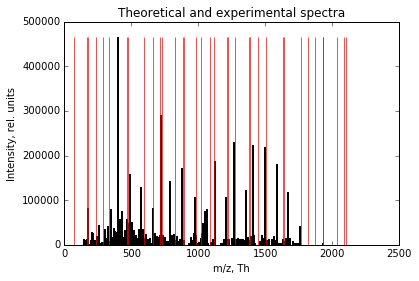

In [11]:
%matplotlib inline
import numpy as np
import pylab
pylab.figure()
pylab.title('Theoretical and experimental spectra')
pylab.xlabel('m/z, Th')
pylab.ylabel('Intensity, rel. units')
pylab.bar(expSpec[:,0], expSpec[:,1], width=0.1, linewidth=2,edgecolor='black')
theor_spectrum = list(ms.getAllFragmentsChargeX(peptideCands.loc[1645,'Sequence'],1).values())
theor_spectrum = np.vstack(theor_spectrum).flatten()
pylab.bar(theor_spectrum,[expSpec[:,1].max()]*len(theor_spectrum),width=0.1, edgecolor='red', alpha=0.7)

## Decoy peak matching

The **reversed decoy peptides** are filtered and the *in silico* y/b ions are derived in exactly the same manner as above.

In [12]:
decoyCands = ms.peptideCandidates(precursorMass,peptideDatabase=decoyPeptideData,massAccuracy=50)
decoyCands = ms.matchExpSpectrumToCandidatePeptides(expMZ,decoyCands,charge=precursorCharge,ms2tolerance=0.1)
display(decoyCands)

,Monoisotopic Mass,Sequence,Score
1660,2101.9246,GCMMEYMVVGLGWWDVAR,0.019178
2146,2101.9341,SFAYHTNLQTSADSGNFDK,0.013699


## Peptide Spectrum Match

For each spectrum, the top scoring peptide is selected as the **peptide spectrum match** (or PSM). Doing this for both the target and decoy database results in a target and decoy PSM as follows:

In [13]:
targetPSM = peptideCands.loc[peptideCands['Score'].idxmax()].copy()
targetPSM['Type'] = 'Target'
targetPSM['Spectrum'] = 'hela1ugul.2404.2404.2.dta'
targetPSM = targetPSM.drop('Monoisotopic Mass')

decoyPSM =decoyCands.loc[decoyCands['Score'].idxmax()].copy()
decoyPSM['Type'] = 'Decoy'
decoyPSM['Spectrum'] = 'hela1ugul.2404.2404.2.dta'
decoyPSM = decoyPSM.drop('Monoisotopic Mass')

print(targetPSM,'\n')
print(decoyPSM)

Sequence    SSGNSSSSGSGSGSTSAGSSSPGAR
Score                        0.112329
Type                           Target
Spectrum    hela1ugul.2404.2404.2.dta
Name: 1657, dtype: object 

Sequence           GCMMEYMVVGLGWWDVAR
Score                       0.0191781
Type                            Decoy
Spectrum    hela1ugul.2404.2404.2.dta
Name: 1660, dtype: object


## Retrieving peptide spectrum matches for all the spectra

The following functions perform all of the procedures we described above, for all the experimental spectra. When running this tool in the command line, all the .dta files in the specified folder will be considered.

The final dataframe at the bottom contains the **top target and decoy PSM's for each spectrum**.

In [14]:
import pandas as pd
def getPSM(spectrumFile,folderPath,ms1Tolerance,ms2Tolerance):
    """
    For the provided spectrum, the peptide spectrum match (PSM) and associated
    score will be computed by filtering peptide candidates from the peptide database,
    using the ms1 tolerance (default = 50 ppm), generating b/y ions
    and calculating their m/z values (with the parent charge minus 1, or 1 for singly charged parents),
    and finally counting the number of matching peaks between the experimental and
    theoretical peptide spectrum (using the ms2 tolerance 0.1 Da).
    The same procedure is repeated by searching against the decoy peptide database.

    Parameters
    ----------
    spectrumFile : str
        The file name of experimental spectrum .dta file.
    folderPath : str
        The folder containing the experimental spectra .dta files.
        Provided by the calling function matchAllSpectra().
    ms1tolerance : float
        The ms1 mass filtering error tolerance to use, in ppm.
    ms2tolerance : float
        The ms2 error tolerance to use during peak matching, in Dalton.

    Returns
    -------
    targetPSM : Series
        A pandas series containing the target PSM score and sequence.
    decoyPSM : Series
        A pandas series containing the decoy PSM score and sequence.
    """

    # Read in experimental spectrum
    expSpec = ms.importExperimentalSpectrum(os.path.normpath(os.path.join(folderPath,spectrumFile)))

    # Retrieve parent mass (M) and charge to use: parent charge minus 1 unless parent charge is 1 already
    precursorMass = ms.getPrecursorMass(expSpec)
    precursorCharge = ms.getPrecursorCharge(expSpec) if ms.getPrecursorCharge(expSpec)==1 else ms.getPrecursorCharge(expSpec)-1

    # Retrieve experimental m/z values
    expMZ = ms.getExperimentalMZs(expSpec)

    # Find peptide candidates in database
    peptideCands = ms.peptideCandidates(precursorMass,peptideDatabase=peptideData,massAccuracy=ms1Tolerance)

    # Calculate scores for peptide candidates - use precursor charge -1
    peptideCands = ms.matchExpSpectrumToCandidatePeptides(expMZ,peptideCands,charge=precursorCharge,ms2tolerance=ms2Tolerance)

    # Retrieve highest score = target peptide spectrum match
    targetPSM = peptideCands.loc[peptideCands['Score'].idxmax()].copy()
    targetPSM['Type'] = 'Target'
    targetPSM['Spectrum'] = spectrumFile
    targetPSM = targetPSM.drop('Monoisotopic Mass')

    # Find peptide candidates in decoys
    decoyCands = ms.peptideCandidates(precursorMass,peptideDatabase=decoyPeptideData,massAccuracy=ms1Tolerance)

    # Calculate scores for peptide candidates - use precursor charge -1
    decoyCands = ms.matchExpSpectrumToCandidatePeptides(expMZ,decoyCands,charge=precursorCharge,ms2tolerance=ms2Tolerance)

    # Retrieve highest decoy score = decoy peptide spectrum match
    decoyPSM =decoyCands.loc[decoyCands['Score'].idxmax()].copy()
    decoyPSM['Type'] = 'Decoy'
    decoyPSM['Spectrum'] = spectrumFile
    decoyPSM = decoyPSM.drop('Monoisotopic Mass')
    
#    print('Peptide matching scores for experimental spectrum ',spectrumFile)
#    print(peptideCands,'\n')
#    print('Target PSM: ',targetPSM,'\n')
#    print('Decoy matching scores for experimental spectrum ',spectrumFile)
#    print(decoyCands,'\n')
#    print('Decoy PSM: ',decoyPSM,'\n')

    return targetPSM,decoyPSM

def matchAllSpectra(pathToSpectra,ms1Tolerance,ms2Tolerance):
    """
    For all the provided spectra files, the target and decoy peptide spectrum match (PSM)
    is returned.

    See the function getPSM() for more details.

    Parameters
    ----------
    pathToSpectra : The absolute path to the spectra .dta files.
    ms1tolerance : float
        The ms1 mass filtering error tolerance to use, in ppm.
    ms2tolerance : float
        The ms2 error tolerance to use during peak matching, in Dalton.

    Returns
    -------
    spectrumScoreDatabase : DataFrame
        A pandas DataFrame containing target and decoy PSM scores for all spectra.
    """

    # Initialise dataframe to store results
    spectrumScoreDatabase = pd.DataFrame()

    for f in os.listdir(pathToSpectra):
        #print('Processing',f)
        if f.endswith(".dta"):
            target,decoy = getPSM(f,folderPath=pathToSpectra,ms1Tolerance=ms1Tolerance,ms2Tolerance=ms2Tolerance)
            spectrumScoreDatabase = spectrumScoreDatabase.append([target,decoy])
        else:
            continue

    # sort scores
    spectrumScoreDatabase = spectrumScoreDatabase.sort_values('Score',ascending=False)

    return spectrumScoreDatabase
PSM = matchAllSpectra(spectraFilePath,ms1Tolerance=50,ms2Tolerance=0.1)
display(PSM)

,Sequence,Score,Type,Spectrum
1657,SSGNSSSSGSGSGSTSAGSSSPGAR,0.112329,Target,hela1ugul.2404.2404.2.dta
1659,LGIYDADGDGDFDVDDAK,0.053608,Target,hela1ugul.12566.12566.2.dta
1730,ADDVDFDGDGDADYIGLK,0.039175,Decoy,hela1ugul.12566.12566.2.dta
1981,QEDSPFQCPK,0.038997,Target,hela1ugul.3746.3746.2.dta
2094,QDCWVQMLR,0.033426,Decoy,hela1ugul.3746.3746.2.dta
1669,GAIETYQEVASLPDVPADLLK,0.029006,Target,hela1ugul.16509.16509.3.dta
1657,SSGNSSSSGSGSGSTSAGSSSPGAR,0.027607,Target,hela1ugul.2406.2406.3.dta
2879,TSPSSSPQLAESPPVNAAWFR,0.019337,Decoy,hela1ugul.16509.16509.3.dta
1660,GCMMEYMVVGLGWWDVAR,0.019178,Decoy,hela1ugul.2404.2404.2.dta
2146,SFAYHTNLQTSADSGNFDK,0.018405,Decoy,hela1ugul.2406.2406.3.dta


## Some notes about target-decoy search strategy

For each experimental spectrum we selected the highest scoring theoretical spectrum as the best match (PSM), but in reality not all of these will be correct matches. Some of the experimental spectra might not be derived from peptide digests of the original protein, but instead stem from contaminating (bio)-molecules. In addition, the correct peptide sequence might not be present in the database or the experimental spectrum might be of poor quality (Elias & Gygi, 2007). 

Because of these issues we need a statistically sound method of calling a match significant. Furthermore, when processing multiple spectra, we should guard ourselves against multiple testing issue, for example by controlling the false discovery rate (FDR) (although P-value or Expectation value based approaches also exist.

The peptide decoy dataset provides an intuitive representation of the **null hypothesis**: any experimental spectrum that is queried against the decoys will result in decoy matches which are by definition incorrect (Elias & Gygi, 2007; Käll et al., 2008). As such, it provides a nice estimation of the number of false positives.

Decoys can be obtained by reversing the original target databases, like was done here, but also by shuffling or stochastically (e.g. using Markov models), and while there is no clear choice for this, the methods generally perform similarly (Jeong, Kim & Bandeira, 2012).

### P-value calculation
The decoy search allows us to calculate p-values by counting how many decoy PSM scores are greater than each target PSM score (Käll et al., 2008). However, note that, similar to Monte Carlo p-values, the accuracy depends on the size of the decoy database. In our case the p-values will only be able to take on five different values, but they are still illustrative.

In [15]:
PSM.loc[:,'P-value'] = PSM.apply(lambda row: (row['Score'] <= PSM.loc[PSM['Type'] == 'Decoy','Score']).sum() / PSM.loc[PSM['Type'] == 'Decoy','Score'].size ,axis=1)
display(PSM)

,Sequence,Score,Type,Spectrum,P-value
1657,SSGNSSSSGSGSGSTSAGSSSPGAR,0.112329,Target,hela1ugul.2404.2404.2.dta,0.0
1659,LGIYDADGDGDFDVDDAK,0.053608,Target,hela1ugul.12566.12566.2.dta,0.0
1730,ADDVDFDGDGDADYIGLK,0.039175,Decoy,hela1ugul.12566.12566.2.dta,0.2
1981,QEDSPFQCPK,0.038997,Target,hela1ugul.3746.3746.2.dta,0.2
2094,QDCWVQMLR,0.033426,Decoy,hela1ugul.3746.3746.2.dta,0.4
1669,GAIETYQEVASLPDVPADLLK,0.029006,Target,hela1ugul.16509.16509.3.dta,0.4
1657,SSGNSSSSGSGSGSTSAGSSSPGAR,0.027607,Target,hela1ugul.2406.2406.3.dta,0.4
2879,TSPSSSPQLAESPPVNAAWFR,0.019337,Decoy,hela1ugul.16509.16509.3.dta,0.6
1660,GCMMEYMVVGLGWWDVAR,0.019178,Decoy,hela1ugul.2404.2404.2.dta,0.8
2146,SFAYHTNLQTSADSGNFDK,0.018405,Decoy,hela1ugul.2406.2406.3.dta,1.0


### Multiple testing and false discovery

The decoy search also provides an elegant way to estimate the false discovery rate (FDR) and guard against multiple testing issues. The FDR describes the expected number of false positives among all significant/accepted PSM's. By setting a scoring or p-value threshold, the FDR is simply the number of decoys PSM's higher than this threshold, divided by the number of target PSM's (Käll et al., 2008): $$ FDR_{t} = \frac{N_{decoy}}{N_{target}} $$ 

where $N_{decoy}$ and $N_{target}$ are the number of PSM scores larger than the threshold $t$.

### Q-values
FDR's can be a bit unintuitive, because they are defined for a set of spectra, rather than being a function of the score or p-value of a single PSM. **Q-values** provide a more elegant solution: they describe the minimum FDR threshold at which the current PSM would still be accepted (Käll et al., 2008; Noble, 2009). In other words, the q-value estimates the number of false positives among all PSM's with a score higher than the current PSM.

Note that the decoy PSM's do not get assigned a q-value.

In [16]:
# reverse PSM list to allow checking if current q-value is larger than previous ones
revPSM = PSM.iloc[::-1].copy()
# initialize q-value column
revPSM['Q-value'] = np.nan
# retrieve decoy and target scores
decoys = revPSM.loc[revPSM['Type'] == 'Decoy']
targets = revPSM.loc[revPSM['Type'] == 'Target']
# set variable to remember previous FDR during loop
previousFDR = 1
# Set the q-value for each PSM to the smallest FDR cut-off at which it would still be accepted
# Prevents q-values for higher scores to be lower than for lower scores by looking back at previous values
for index, row in revPSM.iterrows():
    if row['Type'] == 'Decoy':
        continue
    FDR = (decoys.Score >= row['Score']).sum()/ (targets.Score >= row['Score']).sum()
    FDR = FDR if previousFDR >= FDR else previousFDR
    revPSM.loc[index,'Q-value'] = FDR
    previousFDR = FDR
# return again sorted from high to low
PSM = revPSM.iloc[::-1]
display(PSM)

,Sequence,Score,Type,Spectrum,P-value,Q-value
1657,SSGNSSSSGSGSGSTSAGSSSPGAR,0.112329,Target,hela1ugul.2404.2404.2.dta,0.0,0.000000
1659,LGIYDADGDGDFDVDDAK,0.053608,Target,hela1ugul.12566.12566.2.dta,0.0,0.000000
1730,ADDVDFDGDGDADYIGLK,0.039175,Decoy,hela1ugul.12566.12566.2.dta,0.2,NaN
1981,QEDSPFQCPK,0.038997,Target,hela1ugul.3746.3746.2.dta,0.2,0.333333
2094,QDCWVQMLR,0.033426,Decoy,hela1ugul.3746.3746.2.dta,0.4,NaN
1669,GAIETYQEVASLPDVPADLLK,0.029006,Target,hela1ugul.16509.16509.3.dta,0.4,0.400000
1657,SSGNSSSSGSGSGSTSAGSSSPGAR,0.027607,Target,hela1ugul.2406.2406.3.dta,0.4,0.000000
2879,TSPSSSPQLAESPPVNAAWFR,0.019337,Decoy,hela1ugul.16509.16509.3.dta,0.6,NaN
1660,GCMMEYMVVGLGWWDVAR,0.019178,Decoy,hela1ugul.2404.2404.2.dta,0.8,NaN
2146,SFAYHTNLQTSADSGNFDK,0.018405,Decoy,hela1ugul.2406.2406.3.dta,1.0,NaN


### FDR-filter

The FDR threshold can be set in the command line, but it defaults to 0.05. Because there are so few PSM's in our example, there is no score threshold which exactly corresponds to 0.05, so the function takes the next lower option, which is zero in this case. This also corresponds to selecting all the q-values which are equal to zero. Only the target PSM's that are accepted at the given FDR threshold are retained in the end.

In [17]:
decoys = PSM.loc[PSM['Type']=='Decoy']
targets = PSM.loc[PSM['Type'] == 'Target']
scores = PSM.Score.sort_values()
FDR = 100
for potentialCutOff in scores:
    FDR = (decoys.Score >= potentialCutOff).sum()/ (targets.Score >= potentialCutOff).sum()
    if FDR <= 0.05:
        cutOff = potentialCutOff
        break
accepted = targets.loc[targets['Score'] >= cutOff].copy()
# Drop decoys from dataframe
accepted = accepted[accepted.Type == 'Target']
display(accepted)

,Sequence,Score,Type,Spectrum,P-value,Q-value
1657,SSGNSSSSGSGSGSTSAGSSSPGAR,0.112329,Target,hela1ugul.2404.2404.2.dta,0.0,0.0
1659,LGIYDADGDGDFDVDDAK,0.053608,Target,hela1ugul.12566.12566.2.dta,0.0,0.0


### Concatenated versus separate decoy search

We have performed a separate search against the decoy and target database, but it has been suggested that it is more sensible to perform a concatenated search for the purposes of FDR estimation. In this setting decoy and target PSM scores for the same spectrum are competing directly with each other, which avoids too conservative FDR estimation (Elias & Gygi, 2007; Jeong, Kim & Bandeira, 2012). On the other hand, in our simple setting this would have reduced the number of PSM's to five instead of ten, which would have made inference even more difficult.

## Protein Inference

The final step is to search the sequences in the protein database for sub-string matches to the accepted peptides. A list of the UniProtKB/Swiss-Prot identifiers is appended to each PSM.

We have controlled the FDR at the level of the PSM's, but this does not tell us anything about the FDR at the protein-level (Cottrell, 2011). Our approach does not attempt to assign probabilities to the protein assignments (for methods that do, see Teng, Huang & He (2013) and Reiter et al. (2009)), but we do note that we can be more confident in proteins that are infered from multiple peptides. 

In [18]:
accepted.loc[:,'Inferred Proteins'] = accepted.apply(lambda row: proteinData.loc[proteinData.Sequence.str.contains(row['Sequence'])].Identifier.tolist() ,axis=1)
display(accepted)

,Sequence,Score,Type,Spectrum,P-value,Q-value,Inferred Proteins
1657,SSGNSSSSGSGSGSTSAGSSSPGAR,0.112329,Target,hela1ugul.2404.2404.2.dta,0.0,0.0,"[[Q12797], [Q12797]]"
1659,LGIYDADGDGDFDVDDAK,0.053608,Target,hela1ugul.12566.12566.2.dta,0.0,0.0,"[[Q12797], [Q12797]]"


The above table is the final output that is received upon running this tool. The last column contains the UniProtKB/Swiss-Prot identifiers of all the proteins in the protein database that contain the exact peptide sequence of the PSM's that were accepted.

# References

- Cottrell, J. (2011). Protein identification using MS/MS data. Journal Of Proteomics, 74(10), 1842-1851. http://dx.doi.org/10.1016/j.jprot.2011.05.014
- Elias, J., & Gygi, S. (2007). Target-decoy search strategy for increased confidence in large-scale protein identifications by mass spectrometry. Nature Methods, 4(3), 207-214. http://dx.doi.org/10.1038/nmeth1019
- Jeong, K., Kim, S., & Bandeira, N. (2012). False discovery rates in spectral identification. BMC Bioinformatics, 13(Suppl 16), S2. http://dx.doi.org/10.1186/1471-2105-13-s16-s2
- Käll, L., Storey, J., MacCoss, M., & Noble, W. (2008). Assigning Significance to Peptides Identified by Tandem Mass Spectrometry Using Decoy Databases. J. Proteome Res., 7(1), 29-34. http://dx.doi.org/10.1021/pr700600n
- Noble, W. (2009). How does multiple testing correction work?. Nat Biotechnol, 27(12), 1135-1137. http://dx.doi.org/10.1038/nbt1209-1135
- Reiter, L., Claassen, M., Schrimpf, S., Jovanovic, M., Schmidt, A., & Buhmann, J. et al. (2009). Protein Identification False Discovery Rates for Very Large Proteomics Data Sets Generated by Tandem Mass Spectrometry. Molecular & Cellular Proteomics, 8(11), 2405-2417. http://dx.doi.org/10.1074/mcp.m900317-mcp200
- Sadygov, R., Cociorva, D., & Yates, J. (2004). Large-scale database searching using tandem mass spectra: Looking up the answer in the back of the book. Nature Methods, 1(3), 195-202. http://dx.doi.org/10.1038/nmeth725
- Teng, B., Huang, T., & He, Z. (2013). Decoy-free protein-level false discovery rate estimation. Bioinformatics, 30(5), 675-681. http://dx.doi.org/10.1093/bioinformatics/btt431